In [1]:
# def main(debug=False):
#     num_rows = 10000 if debug else None
#     with timer("train & test"):
#         df = train_test(num_rows)
#     with timer("historical transactions"):
#         df = pd.merge(df, historical_transactions(num_rows), on='card_id', how='outer')
#     with timer("new merchants"):
#         df = pd.merge(df, new_merchant_transactions(num_rows), on='card_id', how='outer')
#     with timer("additional features"):
#         df = additional_features(df)
#     with timer("split train & test"):
#         train_df = df[df['target'].notnull()]
#         test_df = df[df['target'].isnull()]
#         del df
#         gc.collect()
#     with timer("Run LightGBM with kfold"): 
#         kfold_lightgbm(train_df, test_df, num_folds=11, stratified=False, debug=debug)

# if __name__ == "__main__":
#     submission_file_name = "submission.csv"
#     with timer("Full model run"):
#         main(debug=False)

In [73]:
from contextlib import contextmanager
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import os
import time
import gc
import warnings

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold


warnings.simplefilter(action='ignore', category=Warning)
pd.options.mode.chained_assignment = None
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

### Step01 Preprocessing train & test

In [4]:
# load csv
num_rows=None
train_df = pd.read_csv('../data/train.csv', index_col=['card_id'], nrows=num_rows)
test_df = pd.read_csv('../data/test.csv', index_col=['card_id'], nrows=num_rows)

print("Train samples: {}, test samples: {}".format(len(train_df), len(test_df)))
display(train_df.head())
display(test_df.head())
train_df.describe().T

Train samples: 201917, test samples: 123623


,first_active_month,feature_1,feature_2,feature_3,target
card_id,,,,,
C_ID_92a2005557,2017-06,5,2,1,-0.820283
C_ID_3d0044924f,2017-01,4,1,0,0.392913
C_ID_d639edf6cd,2016-08,2,2,0,0.688056
C_ID_186d6a6901,2017-09,4,3,0,0.142495
C_ID_cdbd2c0db2,2017-11,1,3,0,-0.159749


,first_active_month,feature_1,feature_2,feature_3
card_id,,,,
C_ID_0ab67a22ab,2017-04,3,3,1
C_ID_130fd0cbdd,2017-01,2,3,0
C_ID_b709037bc5,2017-08,5,1,1
C_ID_d27d835a9f,2017-12,2,1,0
C_ID_2b5e3df5c2,2015-12,5,1,1


,count,mean,std,min,25%,50%,75%,max
feature_1,201917.0,3.105311,1.186160,1.000000,2.00000,3.000000,4.000000,5.000000
feature_2,201917.0,1.745410,0.751362,1.000000,1.00000,2.000000,2.000000,3.000000
feature_3,201917.0,0.565569,0.495683,0.000000,0.00000,1.000000,1.000000,1.000000
target,201917.0,-0.393636,3.850500,-33.219281,-0.88311,-0.023437,0.765453,17.965068


In [5]:
# outlier
train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1

In [6]:
# set target as nan
test_df['target'] = np.nan

In [7]:
# append train + test vertically ---> df
df = pd.concat([train_df, test_df])
df.shape

(325540, 6)

In [8]:
del train_df, test_df
gc.collect()

0

In [9]:
# to datetime
df['first_active_month'] = pd.to_datetime(df['first_active_month'])

In [10]:
# to datetime
df['first_active_month'] = pd.to_datetime(df['first_active_month'])

# datetime features
df['quarter'] = df['first_active_month'].dt.quarter
df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days

df['days_feature1'] = df['elapsed_time'] * df['feature_1']
df['days_feature2'] = df['elapsed_time'] * df['feature_2']
df['days_feature3'] = df['elapsed_time'] * df['feature_3']

df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']
df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']
df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']

In [11]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

df, cols = one_hot_encoder(df, nan_as_category=False)
display(df.head())
print(cols)

,first_active_month,feature_1,feature_2,feature_3,target,outliers,quarter,elapsed_time,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio
card_id,,,,,,,,,,,,,,
C_ID_92a2005557,2017-06-01,5,2,1,-0.820283,0.0,2.0,2667.0,13335.0,5334.0,2667.0,0.001875,0.000750,0.000375
C_ID_3d0044924f,2017-01-01,4,1,0,0.392913,0.0,1.0,2818.0,11272.0,2818.0,0.0,0.001419,0.000355,0.000000
C_ID_d639edf6cd,2016-08-01,2,2,0,0.688056,0.0,3.0,2971.0,5942.0,5942.0,0.0,0.000673,0.000673,0.000000
C_ID_186d6a6901,2017-09-01,4,3,0,0.142495,0.0,3.0,2575.0,10300.0,7725.0,0.0,0.001553,0.001165,0.000000
C_ID_cdbd2c0db2,2017-11-01,1,3,0,-0.159749,0.0,4.0,2514.0,2514.0,7542.0,0.0,0.000398,0.001193,0.000000


[]


In [12]:
for f in ['feature_1','feature_2','feature_3']:
    order_label = df.groupby([f])['outliers'].mean()
    df[f] = df[f].map(order_label)

df.head()

,first_active_month,feature_1,feature_2,feature_3,target,outliers,quarter,elapsed_time,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio
card_id,,,,,,,,,,,,,,
C_ID_92a2005557,2017-06-01,0.013145,0.008752,0.011428,-0.820283,0.0,2.0,2667.0,13335.0,5334.0,2667.0,0.001875,0.000750,0.000375
C_ID_3d0044924f,2017-01-01,0.010712,0.011385,0.010283,0.392913,0.0,1.0,2818.0,11272.0,2818.0,0.0,0.001419,0.000355,0.000000
C_ID_d639edf6cd,2016-08-01,0.010610,0.008752,0.010283,0.688056,0.0,3.0,2971.0,5942.0,5942.0,0.0,0.000673,0.000673,0.000000
C_ID_186d6a6901,2017-09-01,0.010712,0.014166,0.010283,0.142495,0.0,3.0,2575.0,10300.0,7725.0,0.0,0.001553,0.001165,0.000000
C_ID_cdbd2c0db2,2017-11-01,0.008058,0.014166,0.010283,-0.159749,0.0,4.0,2514.0,2514.0,7542.0,0.0,0.000398,0.001193,0.000000


In [13]:
df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
df['feature_mean'] = df['feature_sum']/3
df['feature_max'] = df[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
df['feature_min'] = df[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
df['feature_var'] = df[['feature_1', 'feature_2', 'feature_3']].std(axis=1)

df.head()

,first_active_month,feature_1,feature_2,feature_3,target,outliers,quarter,elapsed_time,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_mean,feature_max,feature_min,feature_var
card_id,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,2017-06-01,0.013145,0.008752,0.011428,-0.820283,0.0,2.0,2667.0,13335.0,5334.0,2667.0,0.001875,0.000750,0.000375,0.033324,0.011108,0.013145,0.008752,0.002214
C_ID_3d0044924f,2017-01-01,0.010712,0.011385,0.010283,0.392913,0.0,1.0,2818.0,11272.0,2818.0,0.0,0.001419,0.000355,0.000000,0.032379,0.010793,0.011385,0.010283,0.000555
C_ID_d639edf6cd,2016-08-01,0.010610,0.008752,0.010283,0.688056,0.0,3.0,2971.0,5942.0,5942.0,0.0,0.000673,0.000673,0.000000,0.029645,0.009882,0.010610,0.008752,0.000992
C_ID_186d6a6901,2017-09-01,0.010712,0.014166,0.010283,0.142495,0.0,3.0,2575.0,10300.0,7725.0,0.0,0.001553,0.001165,0.000000,0.035161,0.011720,0.014166,0.010283,0.002129
C_ID_cdbd2c0db2,2017-11-01,0.008058,0.014166,0.010283,-0.159749,0.0,4.0,2514.0,2514.0,7542.0,0.0,0.000398,0.001193,0.000000,0.032508,0.010836,0.014166,0.008058,0.003091


### Step02 Preprocessing historical transactions

In [14]:
# load csv
nrows=None
hist_df = pd.read_csv('../data/historical_transactions.csv', nrows=num_rows)

hist_df.head().T
hist_df.shape

(29112361, 14)

In [15]:
hist_df.describe().T

,count,mean,std,min,25%,50%,75%,max
city_id,29112361.0,129.325617,104.256301,-1.000000,53.000000,90.000000,212.000000,3.470000e+02
installments,29112361.0,0.648495,2.795577,-1.000000,0.000000,0.000000,1.000000,9.990000e+02
merchant_category_id,29112361.0,481.013028,249.375714,-1.000000,307.000000,454.000000,705.000000,8.910000e+02
month_lag,29112361.0,-4.487294,3.588800,-13.000000,-7.000000,-4.000000,-2.000000,0.000000e+00
purchase_amount,29112361.0,0.036401,1123.521648,-0.746908,-0.720356,-0.688349,-0.603254,6.010604e+06
category_2,26459497.0,2.194578,1.531896,1.000000,1.000000,1.000000,3.000000,5.000000e+00
state_id,29112361.0,10.566790,6.366927,-1.000000,9.000000,9.000000,16.000000,2.400000e+01
subsector_id,29112361.0,26.848388,9.692793,-1.000000,19.000000,29.000000,34.000000,4.100000e+01


In [16]:
# fillna
hist_df['category_2'].fillna(1.0,inplace=True)
hist_df['category_3'].fillna('A',inplace=True)
hist_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
hist_df['installments'].replace(-1, np.nan,inplace=True)
hist_df['installments'].replace(999, np.nan,inplace=True)

In [17]:
# trim
hist_df['purchase_amount'] = hist_df['purchase_amount'].apply(lambda x: min(x, 0.8))

In [18]:
# Y/N to 1/0
hist_df['authorized_flag'] = hist_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
hist_df['category_1'] = hist_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
hist_df['category_3'] = hist_df['category_3'].map({'A':0, 'B':1, 'C':2})

In [19]:
# datetime features
hist_df['purchase_date'] = pd.to_datetime(hist_df['purchase_date'])
hist_df['month'] = hist_df['purchase_date'].dt.month
hist_df['day'] = hist_df['purchase_date'].dt.day
hist_df['hour'] = hist_df['purchase_date'].dt.hour
hist_df['weekofyear'] = hist_df['purchase_date'].apply(lambda x: x.isocalendar()[1])
hist_df['weekday'] = hist_df['purchase_date'].dt.weekday
hist_df['weekend'] = (hist_df['purchase_date'].dt.weekday >=5).astype(int)

In [20]:
# additional features
hist_df['price'] = hist_df['purchase_amount'] / hist_df['installments']

In [21]:
#Christmas : December 25 2017
hist_df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Mothers Day: May 14 2017
hist_df['Mothers_Day_2017']=(pd.to_datetime('2017-06-04')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#fathers day: August 13 2017
hist_df['fathers_day_2017']=(pd.to_datetime('2017-08-13')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Childrens day: October 12 2017
hist_df['Children_day_2017']=(pd.to_datetime('2017-10-12')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Valentine's Day : 12th June, 2017
hist_df['Valentine_Day_2017']=(pd.to_datetime('2017-06-12')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Black Friday : 24th November 2017
hist_df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

#2018
#Mothers Day: May 13 2018
hist_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

hist_df.shape

(29112361, 28)

In [22]:
hist_df['month_diff'] = ((datetime.datetime.today() - hist_df['purchase_date']).dt.days)//30
hist_df['month_diff'] += hist_df['month_lag']

hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,weekend,price,Christmas_Day_2017,Mothers_Day_2017,fathers_day_2017,Children_day_2017,Valentine_Day_2017,Black_Friday_2017,Mothers_Day_2018,month_diff
0,1,C_ID_4e6213e9bc,88,0,0.0,0,80,M_ID_e020e9b302,-8,-0.703331,...,1,-inf,0,0,48,0,0,0,0,80
1,1,C_ID_4e6213e9bc,88,0,0.0,0,367,M_ID_86ec983688,-7,-0.733128,...,1,-inf,0,0,28,88,0,0,0,80
2,1,C_ID_4e6213e9bc,88,0,0.0,0,80,M_ID_979ed661fc,-6,-0.720386,...,0,-inf,0,0,3,63,0,0,0,80
3,1,C_ID_4e6213e9bc,88,0,0.0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,...,1,-inf,0,0,0,39,0,82,0,80
4,1,C_ID_4e6213e9bc,88,0,0.0,0,80,M_ID_e020e9b302,-11,-0.722865,...,0,-inf,0,85,0,0,93,0,0,80


In [23]:
# additional features
hist_df['duration'] = hist_df['purchase_amount']*hist_df['month_diff']
hist_df['amount_month_ratio'] = hist_df['purchase_amount']/hist_df['month_diff']

In [24]:
# reduce memory usage
# reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

hist_df = reduce_mem_usage(hist_df)

Memory usage after optimization is: 1832.41 MB
Decreased by 71.6%


In [25]:
# Derive aggregate features
col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

aggs = {}
for col in col_unique:
    aggs[col] = ['nunique']

for col in col_seas:
    aggs[col] = ['nunique', 'mean', 'min', 'max']

aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
aggs['installments'] = ['sum','max','mean','var','skew']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var','skew']
aggs['month_diff'] = ['max','min','mean','var','skew']
aggs['authorized_flag'] = ['mean']
aggs['weekend'] = ['mean'] # overwrite
aggs['weekday'] = ['mean'] # overwrite
aggs['day'] = ['nunique', 'mean', 'min'] # overwrite
aggs['category_1'] = ['mean']
aggs['category_2'] = ['mean']
aggs['category_3'] = ['mean']
aggs['card_id'] = ['size','count']
aggs['price'] = ['sum','mean','max','min','var']
aggs['Christmas_Day_2017'] = ['mean']
aggs['Mothers_Day_2017'] = ['mean']
aggs['fathers_day_2017'] = ['mean']
aggs['Children_day_2017'] = ['mean']
aggs['Valentine_Day_2017'] = ['mean']
aggs['Black_Friday_2017'] = ['mean']
aggs['Mothers_Day_2018'] = ['mean']
aggs['duration']=['mean','min','max','var','skew']
aggs['amount_month_ratio']=['mean','min','max','var','skew']

hist_df['category_2'] = hist_df['category_2'].astype('int16')

for col in ['category_2','category_3']:
    hist_df[col+'_mean'] = hist_df.groupby([col])['purchase_amount'].transform('mean')
    hist_df[col+'_min'] = hist_df.groupby([col])['purchase_amount'].transform('min')
    hist_df[col+'_max'] = hist_df.groupby([col])['purchase_amount'].transform('max')
    hist_df[col+'_sum'] = hist_df.groupby([col])['purchase_amount'].transform('sum')
    aggs[col+'_mean'] = ['mean']

hist_df = hist_df.reset_index().groupby('card_id').agg(aggs)
hist_df.head().T

card_id                      C_ID_00007093c1 C_ID_0001238066 C_ID_0001506ef0  \
subsector_id         nunique              13              17              12   
merchant_id          nunique              29              65              28   
merchant_category_id nunique              18              29              19   
month                nunique              12               6              11   
                     mean           6.375839        7.308943         6.80303   
...                                      ...             ...             ...   
amount_month_ratio   max            0.010124        0.009598        0.010002   
                     var             0.00001        0.000006        0.000029   
                     skew            2.82861         4.05571        2.398635   
category_2_mean      mean          -0.593705       -0.606118       -0.591088   
category_3_mean      mean          -0.552033       -0.509526       -0.639323   

card_id                      C_ID_0001793786 C_ID_000183fdda  
subsector_id         nunique              24              21  
merchant_id          nunique             119              73  
merchant_category_id nunique              48              36  
month                nunique              10               7  
                     mean           6.671296        6.881944  
...                                      ...             ...  
amount_month_ratio   max            0.009636        0.010002  
                     var            0.000033        0.000021  
                     skew           1.292595        2.549789  
category_2_mean      mean          -0.601817       -0.591955  
category_3_mean      mean          -0.639181       -0.510981  

[73 rows x 5 columns]

In [26]:
hist_df.columns.tolist()[:10]

[('subsector_id', 'nunique'),
 ('merchant_id', 'nunique'),
 ('merchant_category_id', 'nunique'),
 ('month', 'nunique'),
 ('month', 'mean'),
 ('month', 'min'),
 ('month', 'max'),
 ('hour', 'nunique'),
 ('hour', 'mean'),
 ('hour', 'min')]

In [27]:
# change column name
hist_df.columns = pd.Index([e[0] + "_" + e[1] for e in hist_df.columns.tolist()])
hist_df.columns = ['hist_'+ c for c in hist_df.columns]
hist_df.head()

,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_month_nunique,hist_month_mean,hist_month_min,hist_month_max,hist_hour_nunique,hist_hour_mean,hist_hour_min,...,hist_duration_max,hist_duration_var,hist_duration_skew,hist_amount_month_ratio_mean,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_var,hist_amount_month_ratio_skew,hist_category_2_mean_mean,hist_category_3_mean_mean
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,13,29,18,12,6.375839,1,12,18,14.416107,0,...,63.1875,409.647766,2.794278,-0.006552,-0.009132,0.010124,0.000010,2.828610,-0.593705,-0.552033
C_ID_0001238066,17,65,29,6,7.308943,1,12,20,14.739837,0,...,61.4375,231.216766,4.054609,-0.007376,-0.009224,0.009598,0.000006,4.055710,-0.606118,-0.509526
C_ID_0001506ef0,12,28,19,11,6.803030,1,12,15,12.606061,0,...,64.0000,1168.780396,2.398956,-0.006709,-0.009361,0.010002,0.000029,2.398635,-0.591088,-0.639323
C_ID_0001793786,24,119,48,10,6.671296,1,10,21,15.606481,0,...,67.1875,1645.703003,1.295555,-0.003365,-0.008980,0.009636,0.000033,1.292595,-0.601817,-0.639181
C_ID_000183fdda,21,73,36,7,6.881944,1,12,19,16.465278,0,...,64.0000,856.993469,2.555576,-0.006434,-0.009224,0.010002,0.000021,2.549789,-0.591955,-0.510981


In [28]:
hist_df['hist_purchase_date_diff'] = (hist_df['hist_purchase_date_max']-hist_df['hist_purchase_date_min']).dt.days
hist_df['hist_purchase_date_average'] = hist_df['hist_purchase_date_diff']/hist_df['hist_card_id_size']
hist_df['hist_purchase_date_uptonow'] = (datetime.datetime.today()-hist_df['hist_purchase_date_max']).dt.days
hist_df['hist_purchase_date_uptomin'] = (datetime.datetime.today()-hist_df['hist_purchase_date_min']).dt.days

# reduce memory usage
hist_df = reduce_mem_usage(hist_df)

Memory usage after optimization is: 56.19 MB
Decreased by 60.4%


In [29]:
hist_df.shape

(325540, 77)

In [30]:
df = pd.merge(df, hist_df, on='card_id', how='outer')
df.head()

,first_active_month,feature_1,feature_2,feature_3,target,outliers,quarter,elapsed_time,days_feature1,days_feature2,...,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_var,hist_amount_month_ratio_skew,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_purchase_date_uptomin
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,2017-02-01,0.013145,0.011385,0.011428,0.134077,0.0,1.0,2787.0,13935.0,2787.0,...,-0.009132,0.010124,0.000010,2.828125,-0.593750,-0.552246,377,2.529297,2396,2774
C_ID_0001238066,2017-09-01,0.010712,0.011385,0.010283,NaN,NaN,3.0,2575.0,10300.0,2575.0,...,-0.009224,0.009598,0.000006,4.054688,-0.605957,-0.509766,151,1.227539,2396,2547
C_ID_0001506ef0,2016-07-01,0.010610,0.008752,0.010283,0.884295,0.0,3.0,3002.0,6004.0,6004.0,...,-0.009361,0.010002,0.000029,2.398438,-0.591309,-0.639160,398,6.031250,2406,2805
C_ID_0001793786,2017-01-01,0.013145,0.008752,0.011428,NaN,NaN,1.0,2818.0,14090.0,5636.0,...,-0.008980,0.009636,0.000033,1.292969,-0.602051,-0.639160,283,1.310547,2515,2798
C_ID_000183fdda,2017-09-01,0.010712,0.011385,0.010283,-0.264433,0.0,3.0,2575.0,10300.0,2575.0,...,-0.009224,0.010002,0.000021,2.548828,-0.591797,-0.510742,202,1.402344,2397,2600


In [31]:
df.head().T

card_id,C_ID_00007093c1,C_ID_0001238066,C_ID_0001506ef0,C_ID_0001793786,C_ID_000183fdda
first_active_month,2017-02-01 00:00:00,2017-09-01 00:00:00,2016-07-01 00:00:00,2017-01-01 00:00:00,2017-09-01 00:00:00
feature_1,0.013145,0.010712,0.01061,0.013145,0.010712
feature_2,0.011385,0.011385,0.008752,0.008752,0.011385
feature_3,0.011428,0.010283,0.010283,0.011428,0.010283
target,0.134077,NaN,0.884295,NaN,-0.264433
...,...,...,...,...,...
hist_category_3_mean_mean,-0.552246,-0.509766,-0.63916,-0.63916,-0.510742
hist_purchase_date_diff,377,151,398,283,202
hist_purchase_date_average,2.529297,1.227539,6.03125,1.310547,1.402344
hist_purchase_date_uptonow,2396,2396,2406,2515,2397


In [32]:
df.shape

(325540, 96)

### Step03 Preprocessing historical transactions new_merchant_transactions

In [33]:
# load csv
nrows=None
new_merchant_df = pd.read_csv('../data/new_merchant_transactions.csv', nrows=num_rows)
display(new_merchant_df.head())
new_merchant_df.shape



,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


(1963031, 14)

In [34]:
# fillna
new_merchant_df['category_2'].fillna(1.0,inplace=True)
new_merchant_df['category_3'].fillna('A',inplace=True)
new_merchant_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
new_merchant_df['installments'].replace(-1, np.nan,inplace=True)
new_merchant_df['installments'].replace(999, np.nan,inplace=True)

In [35]:
# trim
new_merchant_df['purchase_amount'] = new_merchant_df['purchase_amount'].apply(lambda x: min(x, 0.8))

In [36]:
# Y/N to 1/0
new_merchant_df['authorized_flag'] = new_merchant_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
new_merchant_df['category_1'] = new_merchant_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
new_merchant_df['category_3'] = new_merchant_df['category_3'].map({'A':0, 'B':1, 'C':2}).astype(int)

In [37]:
# datetime features
new_merchant_df['purchase_date'] = pd.to_datetime(new_merchant_df['purchase_date'])
new_merchant_df['month'] = new_merchant_df['purchase_date'].dt.month
new_merchant_df['day'] = new_merchant_df['purchase_date'].dt.day
new_merchant_df['hour'] = new_merchant_df['purchase_date'].dt.hour
new_merchant_df['weekofyear'] = new_merchant_df['purchase_date'].apply(lambda x: x.isocalendar()[1])
new_merchant_df['weekday'] = new_merchant_df['purchase_date'].dt.weekday
new_merchant_df['weekend'] = (new_merchant_df['purchase_date'].dt.weekday >=5).astype(int)

In [38]:
# additional features
new_merchant_df['price'] = new_merchant_df['purchase_amount'] / new_merchant_df['installments']

In [39]:
#Christmas : December 25 2017
new_merchant_df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Childrens day: October 12 2017
new_merchant_df['Children_day_2017']=(pd.to_datetime('2017-10-12')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Black Friday : 24th November 2017
new_merchant_df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

#Mothers Day: May 13 2018
new_merchant_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)


In [40]:
new_merchant_df['month_diff'] = ((datetime.datetime.today() - new_merchant_df['purchase_date']).dt.days)//30
new_merchant_df['month_diff'] += new_merchant_df['month_lag']

In [41]:
# additional features
new_merchant_df['duration'] = new_merchant_df['purchase_amount']*new_merchant_df['month_diff']
new_merchant_df['amount_month_ratio'] = new_merchant_df['purchase_amount']/new_merchant_df['month_diff']

In [42]:
# reduce memory usage
new_merchant_df = reduce_mem_usage(new_merchant_df)

Memory usage after optimization is: 117.94 MB
Decreased by 69.7%


In [43]:
col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

aggs = {}
for col in col_unique:
    aggs[col] = ['nunique']

for col in col_seas:
    aggs[col] = ['nunique', 'mean', 'min', 'max']

aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
aggs['installments'] = ['sum','max','mean','var','skew']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var','skew']
aggs['month_diff'] = ['mean','var','skew']
aggs['weekend'] = ['mean']
aggs['month'] = ['mean', 'min', 'max']
aggs['weekday'] = ['mean', 'min', 'max']
aggs['category_1'] = ['mean']
aggs['category_2'] = ['mean']
aggs['category_3'] = ['mean']
aggs['card_id'] = ['size','count']
aggs['price'] = ['mean','max','min','var']
aggs['Christmas_Day_2017'] = ['mean']
aggs['Children_day_2017'] = ['mean']
aggs['Black_Friday_2017'] = ['mean']
aggs['Mothers_Day_2018'] = ['mean']
aggs['duration']=['mean','min','max','var','skew']
aggs['amount_month_ratio']=['mean','min','max','var','skew']

new_merchant_df['category_2'] = new_merchant_df['category_2'].astype('int16')

for col in ['category_2','category_3']:
    new_merchant_df[col+'_mean'] = new_merchant_df.groupby([col])['purchase_amount'].transform('mean')
    new_merchant_df[col+'_min'] = new_merchant_df.groupby([col])['purchase_amount'].transform('min')
    new_merchant_df[col+'_max'] = new_merchant_df.groupby([col])['purchase_amount'].transform('max')
    new_merchant_df[col+'_sum'] = new_merchant_df.groupby([col])['purchase_amount'].transform('sum')
    aggs[col+'_mean'] = ['mean']

new_merchant_df = new_merchant_df.reset_index().groupby('card_id').agg(aggs)
new_merchant_df.shape

(290001, 68)

In [44]:
# change column name
new_merchant_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_merchant_df.columns.tolist()])
new_merchant_df.columns = ['new_'+ c for c in new_merchant_df.columns]

new_merchant_df['new_purchase_date_diff'] = (new_merchant_df['new_purchase_date_max']-new_merchant_df['new_purchase_date_min']).dt.days
new_merchant_df['new_purchase_date_average'] = new_merchant_df['new_purchase_date_diff']/new_merchant_df['new_card_id_size']
new_merchant_df['new_purchase_date_uptonow'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_max']).dt.days
new_merchant_df['new_purchase_date_uptomin'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_min']).dt.days


In [45]:
new_merchant_df = reduce_mem_usage(new_merchant_df)
new_merchant_df.shape

Memory usage after optimization is: 44.53 MB
Decreased by 60.5%


(290001, 72)

In [46]:
df = pd.merge(df, new_merchant_df, on='card_id', how='outer')
df.head()

,first_active_month,feature_1,feature_2,feature_3,target,outliers,quarter,elapsed_time,days_feature1,days_feature2,...,new_amount_month_ratio_min,new_amount_month_ratio_max,new_amount_month_ratio_var,new_amount_month_ratio_skew,new_category_2_mean_mean,new_category_3_mean_mean,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,new_purchase_date_uptomin
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,2017-02-01,0.013145,0.011385,0.011428,0.134077,0.0,1.0,2787.0,13935.0,2787.0,...,-0.008400,-0.008209,0.000000,NaN,-0.582520,-0.618652,6.0,3.000000,2355.0,2361.0
C_ID_0001238066,2017-09-01,0.010712,0.011385,0.010283,NaN,NaN,3.0,2575.0,10300.0,2575.0,...,-0.009262,-0.000979,0.000005,1.586914,-0.584473,-0.553711,60.0,2.308594,2334.0,2394.0
C_ID_0001506ef0,2016-07-01,0.010610,0.008752,0.010283,0.884295,0.0,3.0,3002.0,6004.0,6004.0,...,-0.009148,-0.008942,0.000000,NaN,-0.580078,-0.612305,5.0,2.500000,2373.0,2378.0
C_ID_0001793786,2017-01-01,0.013145,0.008752,0.011428,NaN,NaN,1.0,2818.0,14090.0,5636.0,...,-0.008781,0.009636,0.000041,0.884766,-0.583008,-0.612305,46.0,1.483398,2454.0,2500.0
C_ID_000183fdda,2017-09-01,0.010712,0.011385,0.010283,-0.264433,0.0,3.0,2575.0,10300.0,2575.0,...,-0.009155,-0.001363,0.000005,2.285156,-0.580078,-0.464600,59.0,5.363281,2334.0,2393.0


In [47]:
df.shape

(325540, 168)

### Step04 additional features

In [48]:
# Date Features
df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days

date_features=['hist_purchase_date_max','hist_purchase_date_min',
                'new_purchase_date_max', 'new_purchase_date_min']

for f in date_features:
    df[f] = df[f].astype(np.int64) * 1e-9


In [49]:
df.head()

,first_active_month,feature_1,feature_2,feature_3,target,outliers,quarter,elapsed_time,days_feature1,days_feature2,...,new_category_2_mean_mean,new_category_3_mean_mean,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,new_purchase_date_uptomin,hist_first_buy,hist_last_buy,new_first_buy,new_last_buy
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,2017-02-01,0.013145,0.011385,0.011428,0.134077,0.0,1.0,2787.0,13935.0,2787.0,...,-0.582520,-0.618652,6.0,3.000000,2355.0,2361.0,13.0,391.0,426.0,432.0
C_ID_0001238066,2017-09-01,0.010712,0.011385,0.010283,NaN,NaN,3.0,2575.0,10300.0,2575.0,...,-0.584473,-0.553711,60.0,2.308594,2334.0,2394.0,27.0,179.0,181.0,241.0
C_ID_0001506ef0,2016-07-01,0.010610,0.008752,0.010283,0.884295,0.0,3.0,3002.0,6004.0,6004.0,...,-0.580078,-0.612305,5.0,2.500000,2373.0,2378.0,197.0,596.0,623.0,629.0
C_ID_0001793786,2017-01-01,0.013145,0.008752,0.011428,NaN,NaN,1.0,2818.0,14090.0,5636.0,...,-0.583008,-0.612305,46.0,1.483398,2454.0,2500.0,20.0,303.0,318.0,364.0
C_ID_000183fdda,2017-09-01,0.010712,0.011385,0.010283,-0.264433,0.0,3.0,2575.0,10300.0,2575.0,...,-0.580078,-0.464600,59.0,5.363281,2334.0,2393.0,-25.0,177.0,182.0,241.0


In [50]:
df['card_id_total'] = df['new_card_id_size']+df['hist_card_id_size']
df['card_id_cnt_total'] = df['new_card_id_count']+df['hist_card_id_count']
df['card_id_cnt_ratio'] = df['new_card_id_count']/df['hist_card_id_count']

df['purchase_amount_total'] = df['new_purchase_amount_sum']+df['hist_purchase_amount_sum']
df['purchase_amount_mean'] = df['new_purchase_amount_mean']+df['hist_purchase_amount_mean']
df['purchase_amount_max'] = df['new_purchase_amount_max']+df['hist_purchase_amount_max']
df['purchase_amount_min'] = df['new_purchase_amount_min']+df['hist_purchase_amount_min']
df['purchase_amount_ratio'] = df['new_purchase_amount_sum']/df['hist_purchase_amount_sum']

df['month_diff_mean'] = df['new_month_diff_mean']+df['hist_month_diff_mean']
df['month_diff_ratio'] = df['new_month_diff_mean']/df['hist_month_diff_mean']

df['month_lag_mean'] = df['new_month_lag_mean']+df['hist_month_lag_mean']
df['month_lag_max'] = df['new_month_lag_max']+df['hist_month_lag_max']
df['month_lag_min'] = df['new_month_lag_min']+df['hist_month_lag_min']

df['category_1_mean'] = df['new_category_1_mean']+df['hist_category_1_mean']

df['installments_total'] = df['new_installments_sum']+df['hist_installments_sum']
df['installments_mean'] = df['new_installments_mean']+df['hist_installments_mean']
df['installments_max'] = df['new_installments_max']+df['hist_installments_max']
df['installments_ratio'] = df['new_installments_sum']/df['hist_installments_sum']

df['price_total'] = df['purchase_amount_total'] / df['installments_total']
df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
df['price_max'] = df['purchase_amount_max'] / df['installments_max']

df['duration_mean'] = df['new_duration_mean']+df['hist_duration_mean']
df['duration_min'] = df['new_duration_min']+df['hist_duration_min']
df['duration_max'] = df['new_duration_max']+df['hist_duration_max']

df['amount_month_ratio_mean']=df['new_amount_month_ratio_mean']+df['hist_amount_month_ratio_mean']
df['amount_month_ratio_min']=df['new_amount_month_ratio_min']+df['hist_amount_month_ratio_min']
df['amount_month_ratio_max']=df['new_amount_month_ratio_max']+df['hist_amount_month_ratio_max']

df['new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
df['hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']


### Step05 Split Train & Test Set

In [51]:
train_df = df[df['target'].notnull()]
test_df = df[df['target'].isnull()]
del df
gc.collect()

80

### Step06 LightGBM GBDT with KFold or Stratified KFold

In [52]:
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Starting LightGBM. Train shape: (201917, 202), test shape: (123623, 202)


In [53]:
num_folds = 11
folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)
print(type(folds))

<class 'sklearn.model_selection._split.KFold'>


K-Fold cross-validator.

Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).

Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

In [54]:
# Create arrays and dataframes to store results
FEATS_EXCLUDED = ['first_active_month', 'target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0']

oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

fold.split(X, y=None, groups=None)[source]
Generate indices to split data into training and test set.

Parameters
:
X
array-like of shape (n_samples, n_features)
Training data, where n_samples is the number of samples and n_features is the number of features.

y
array-like of shape (n_samples,)
The target variable for supervised learning problems.

groups
object
Always ignored, exists for compatibility.

In [64]:
# rmse
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [70]:
# k-fold
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

    # set data structure
    lgb_train = lgb.Dataset(train_x,
                            label=train_y,
                            free_raw_data=False)
    lgb_test = lgb.Dataset(valid_x,
                            label=valid_y,
                            free_raw_data=False)

    # params optimized by optuna
    params ={
            'task': 'train',
            'boosting': 'goss',
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.01,
            'subsample': 0.9855232997390695,
            'max_depth': 7,
            'top_rate': 0.9064148448434349,
            'num_leaves': 63,
            'min_child_weight': 41.9612869171337,
            'other_rate': 0.0721768246018207,
            'reg_alpha': 9.677537745007898,
            'colsample_bytree': 0.5665320670155495,
            'min_split_gain': 9.820197773625843,
            'reg_lambda': 8.2532317400459,
            'min_data_in_leaf': 21,
            'verbose': -1,
            'seed':int(2**n_fold),
            'bagging_seed':int(2**n_fold),
            'drop_seed':int(2**n_fold),
            'verbose_eval':100 # LightGBM will print the evaluation metric every 100 iterations, helping you track the model's performance during training.
            }

    reg = lgb.train(
                    params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    valid_names=['train', 'test'],
                    num_boost_round=10000,
                    callbacks=[lgb.early_stopping(stopping_rounds=3)]
                    )

    oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
    sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
    del reg, train_x, train_y, valid_x, valid_y
    gc.collect()

# display importances

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[427]	train's rmse: 3.48443	test's rmse: 3.79441
Fold  1 RMSE : 3.794413
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[290]	train's rmse: 3.55442	test's rmse: 3.4873
Fold  2 RMSE : 3.487304
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[391]	train's rmse: 3.50115	test's rmse: 3.7011
Fold  3 RMSE : 3.701096
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[322]	train's rmse: 3.52958	test's rmse: 3.62433
Fold  4 RMSE : 3.624325
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[372]	train's rmse: 3.48609	test's rmse: 3.88353
Fold  5 RMSE : 3.883528
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[517]	train's rmse: 3.47392	test's rmse: 3.62797
Fold  6 RMSE : 3.6

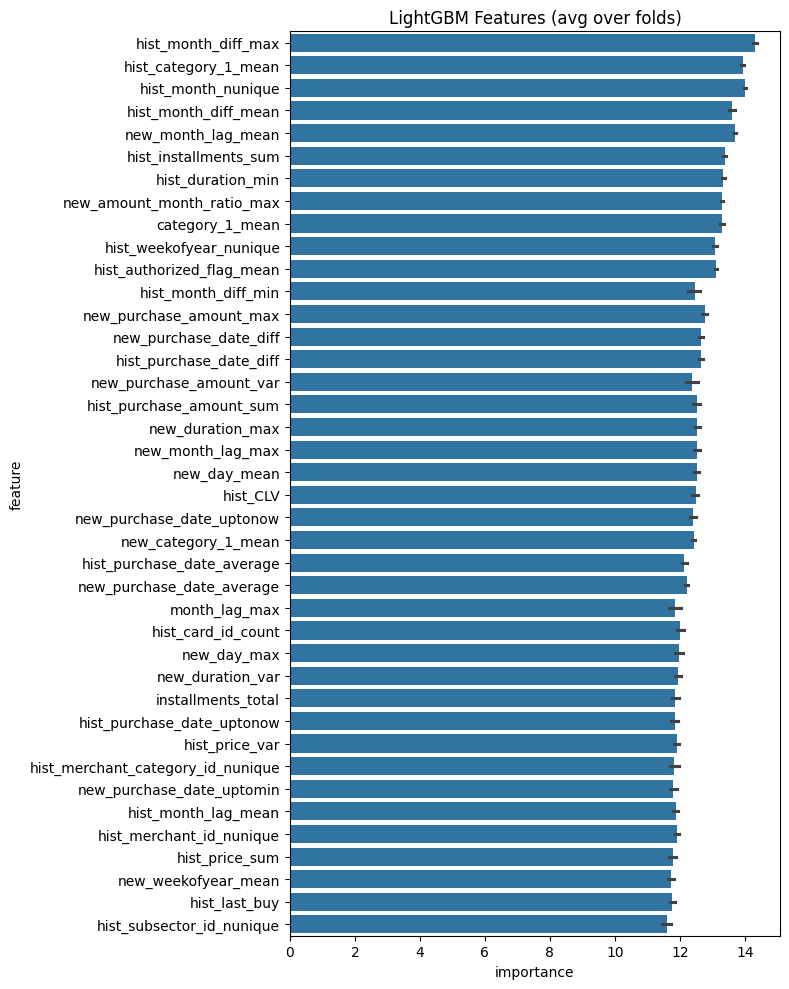

In [74]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

display_importances(feature_importance_df)

In [75]:
# save submission file
submission_file_name = "submission.csv"
test_df.loc[:,'target'] = sub_preds
test_df = test_df.reset_index()
test_df[['card_id', 'target']].to_csv(submission_file_name, index=False)

